In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [42]:
df = pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")

In [43]:
df1 = df.copy()

In [44]:
df1.head()


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [45]:
df1.isnull().sum()


Quarter    0
Sales      0
dtype: int64

In [46]:
df1.dtypes


Quarter     object
Sales      float64
dtype: object

In [47]:
df1.describe().T


,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [48]:
temp = df1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')


In [49]:
df1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')


In [51]:
df1.head()


,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [52]:
df1 = df1.drop(['Quarter'], axis=1)



In [53]:
df1.reset_index(inplace=True)


In [54]:
df1['quater'] = pd.to_datetime(df1['quater'])


In [55]:
df1 = df1.set_index('quater')


In [56]:
df1.head()


,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


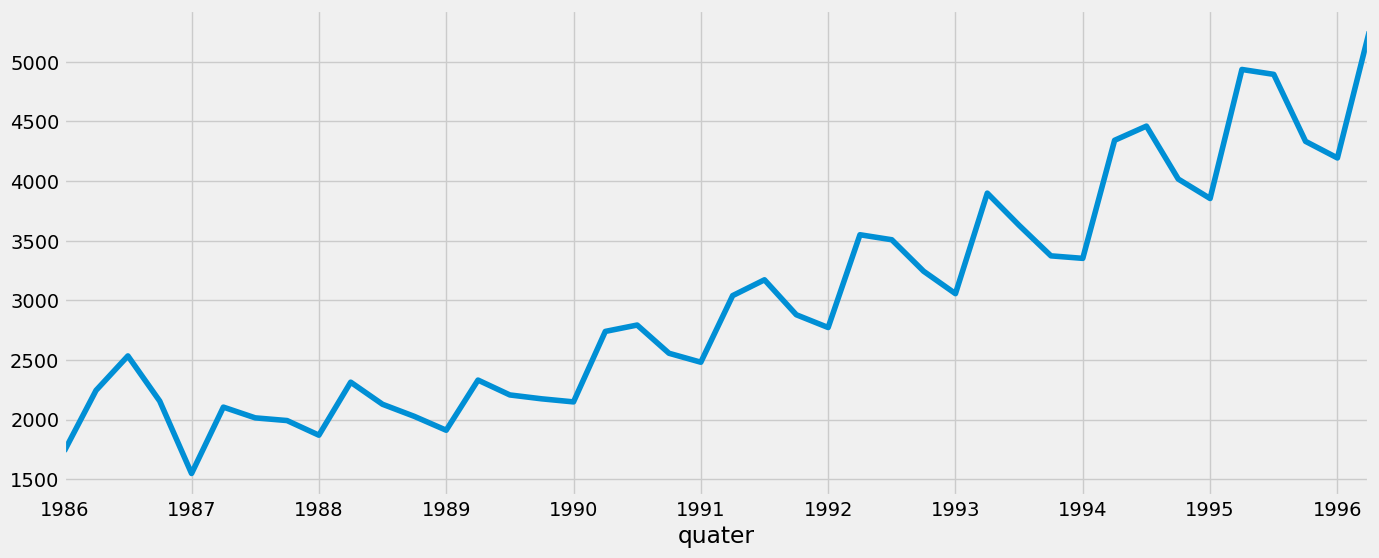

In [57]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

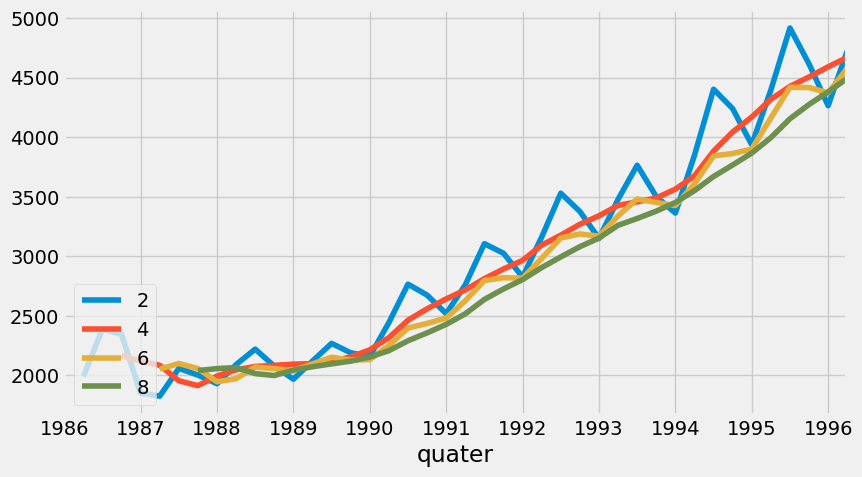

In [59]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

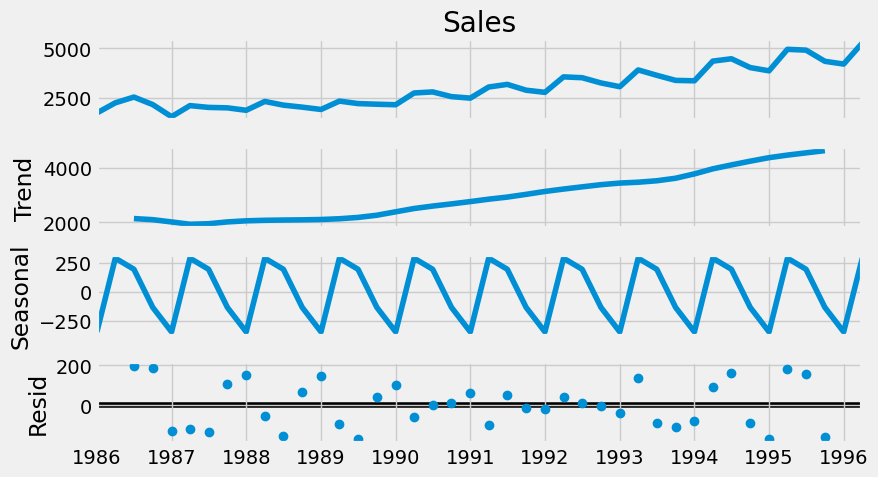

In [60]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

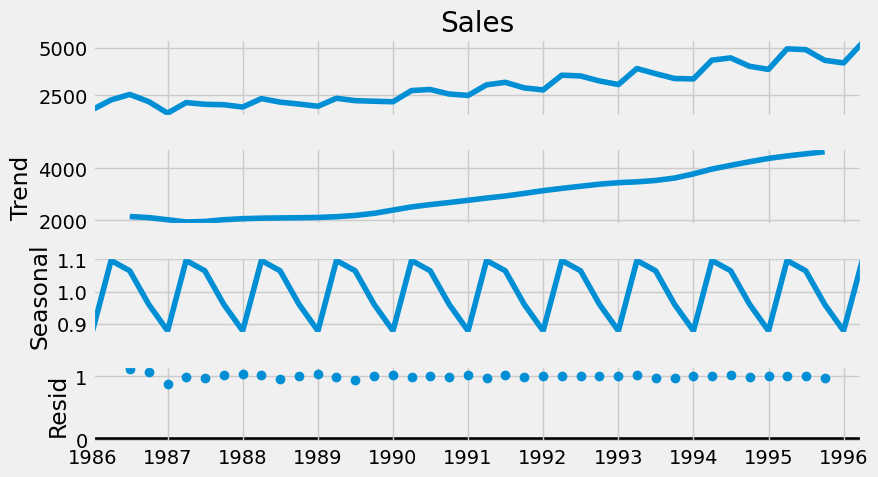

In [61]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

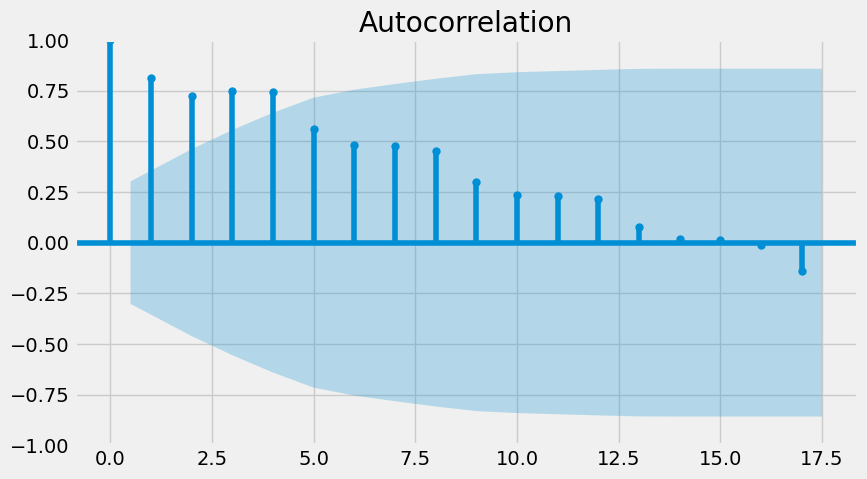

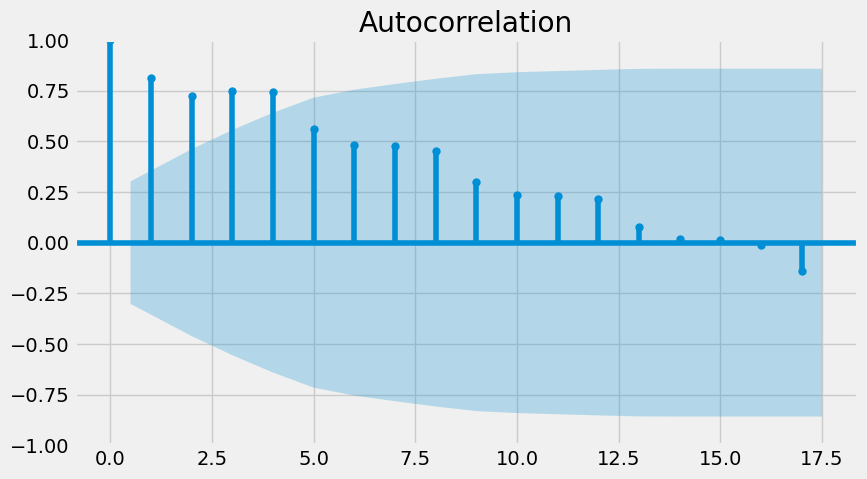

In [62]:
tsa_plots.plot_acf(df1.Sales)



Building Time series forecasting with ARIMA

In [63]:
X = df1['Sales'].values

In [64]:
size = int(len(X) * 0.66)


In [65]:
train, test = X[0:size], X[size:len(X)]


In [69]:
model = sm.tsa.arima.ARIMA(train, order=(5,1,0))

In [72]:
model_fit = model.fit()


In [73]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -174.082
Date:                Fri, 25 Aug 2023   AIC                            360.163
Time:                        18:18:12   BIC                            367.712
Sample:                             0   HQIC                           362.337
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1024      0.306     -0.335      0.738      -0.702       0.497
ar.L2         -0.2140      0.160     -1.338      0.181      -0.527       0.099
ar.L3         -0.0892      0.191     -0.468      0.6

This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

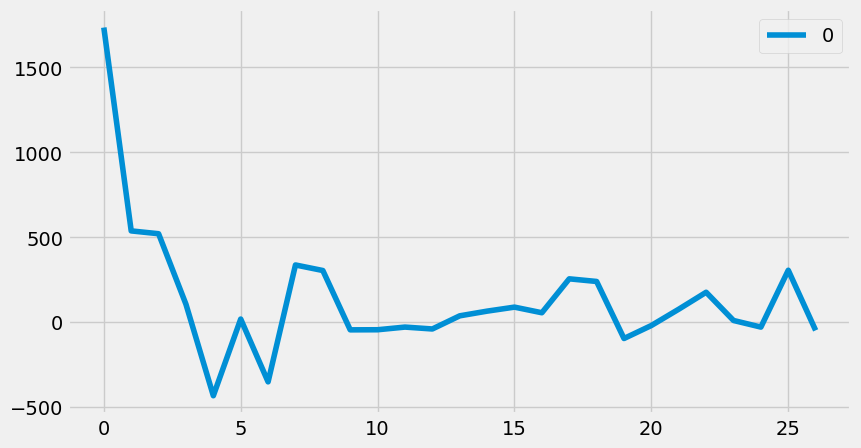

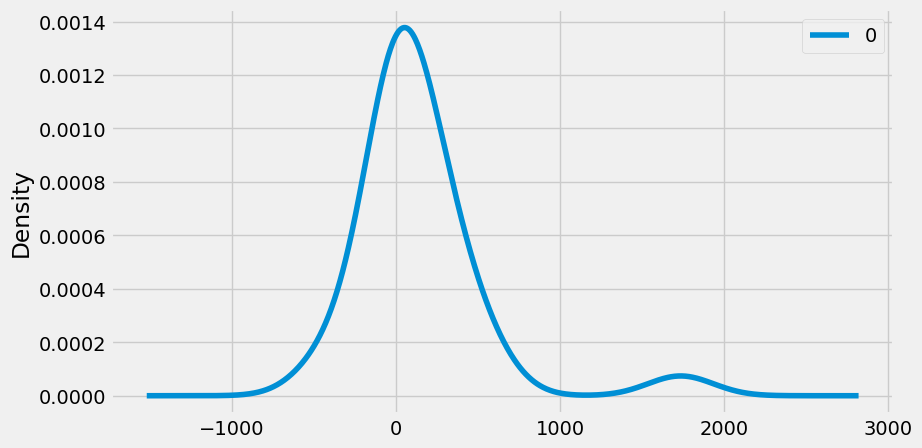

                 0
count    27.000000
mean    137.791854
std     385.970462
min    -433.659591
25%     -34.938856
50%      55.067398
75%     247.080157
max    1734.827000


In [74]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The plot of the residual errors suggests that there may still be some trend information not captured by the model

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)


Rolling Forecast ARIMA Model

In [76]:
history = [x for x in train]


In [77]:
predictions = list()


In [81]:
for t in range(len(test)):
	model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3130.132560, expected=3243.859993
predicted=3167.315971, expected=3056.000000
predicted=3717.472606, expected=3899.000000
predicted=3775.837500, expected=3629.000000
predicted=3332.744953, expected=3373.000000
predicted=3258.575374, expected=3352.000000
predicted=4081.006044, expected=4342.000000
predicted=3955.784129, expected=4461.000000
predicted=4146.277764, expected=4017.000000
predicted=3958.436605, expected=3854.000000
predicted=4701.652928, expected=4936.000000
predicted=4990.071243, expected=4895.000000
predicted=4390.352764, expected=4333.000000
predicted=4190.945470, expected=4194.000000
predicted=5177.006981, expected=5253.000000


In [82]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 34279.908


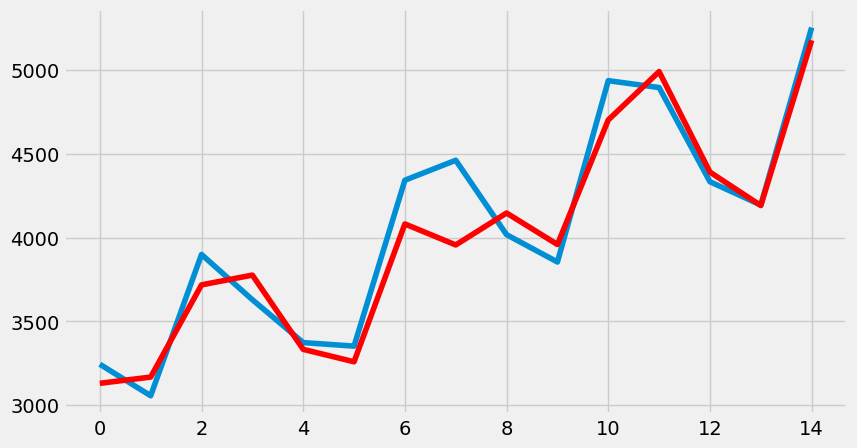

In [83]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale

Comparing Multiple Models


In [85]:
df2 = pd.get_dummies(df, columns = ['Quarter'])


In [86]:
df2.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']


In [87]:
df2.head()


,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2154.962997,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
t= np.arange(1,43)


In [89]:
df2['t'] = t


In [90]:
df2['t_sq'] = df2['t']*df2['t']


In [91]:
log_Sales=np.log(df2['Sales'])


In [92]:
df2['log_Sales']=log_Sales


In [93]:
df2.head()


,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,t,t_sq,log_Sales
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7.458663
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7.716443
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,7.837477
3,2154.962997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,7.675529
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,7.344602


In [94]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])


In [95]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918635

In [96]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037553

In [97]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900199

In [98]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.7188209186954

In [99]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372298

In [100]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.1144436053725

In [101]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.9194407954424

In [102]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.6879119332325

In [103]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

3630.56194673477

Conclusion

In [104]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}


In [105]:
rmse=pd.DataFrame(output)


In [106]:
print(rmse)


           Model       Values
0  rmse_mul_quad  3630.561947
1        rmseadd  1869.718821
2  rmseaddlinear   596.152628
3    rmseaddquad   412.114444
4       rmseexpo   588.140510
5        rmselin   580.122413
6        rmsemul  2374.919441
7      rmsemulin  5359.687912
8       rmsequad   783.729798


Additive seasonality with quadratic trend has the best RMSE value